## Galaxy_Zoo

In [6]:
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import time
from time import strftime
from time import gmtime

#### Affichage des galaxies

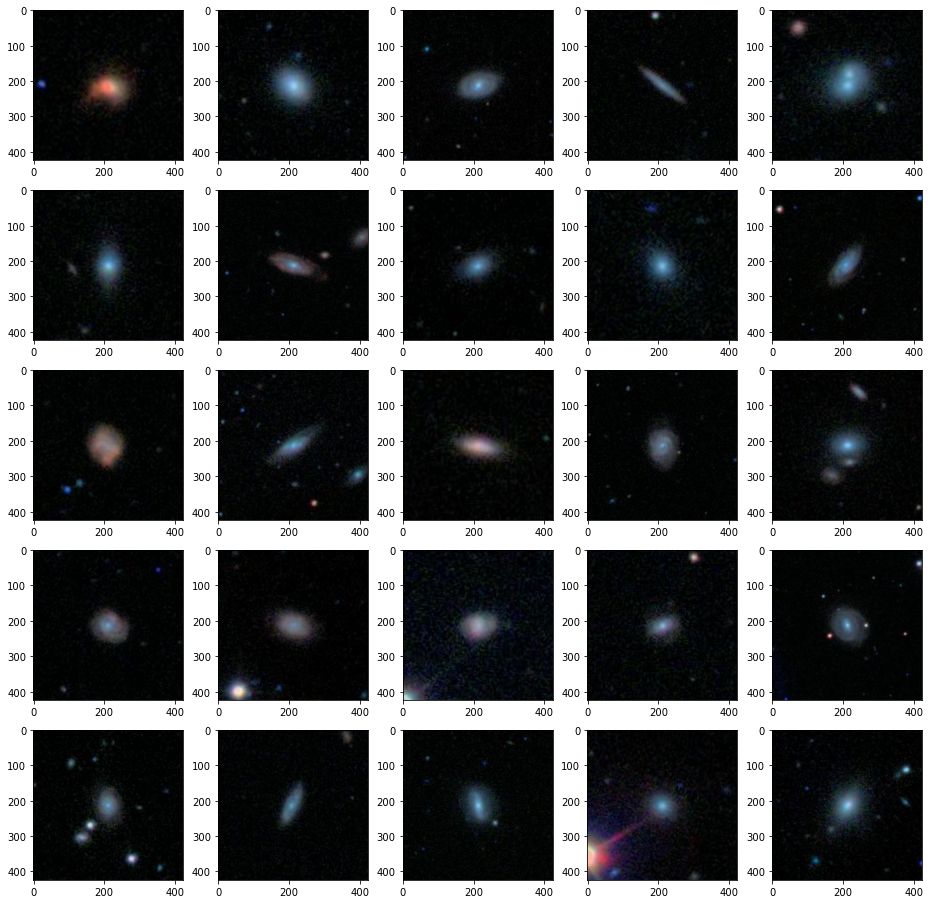

In [3]:
def display_galaxies(n_galaxies = 10):
    path = "data/images_training_rev1/"
    img_list = glob.glob(path+"*.jpg")
    N = len(img_list)
    selected = np.random.choice(N, 25, replace = False)
    plt.figure(figsize=(16,16))

    for i in range(n_galaxies):
        plt.subplot(5,5,i+1)
        img = cv2.imread(img_list[selected[i]])
        plt.imshow(img)

display_galaxies(25)

#### Quelques essais de traitement d'images

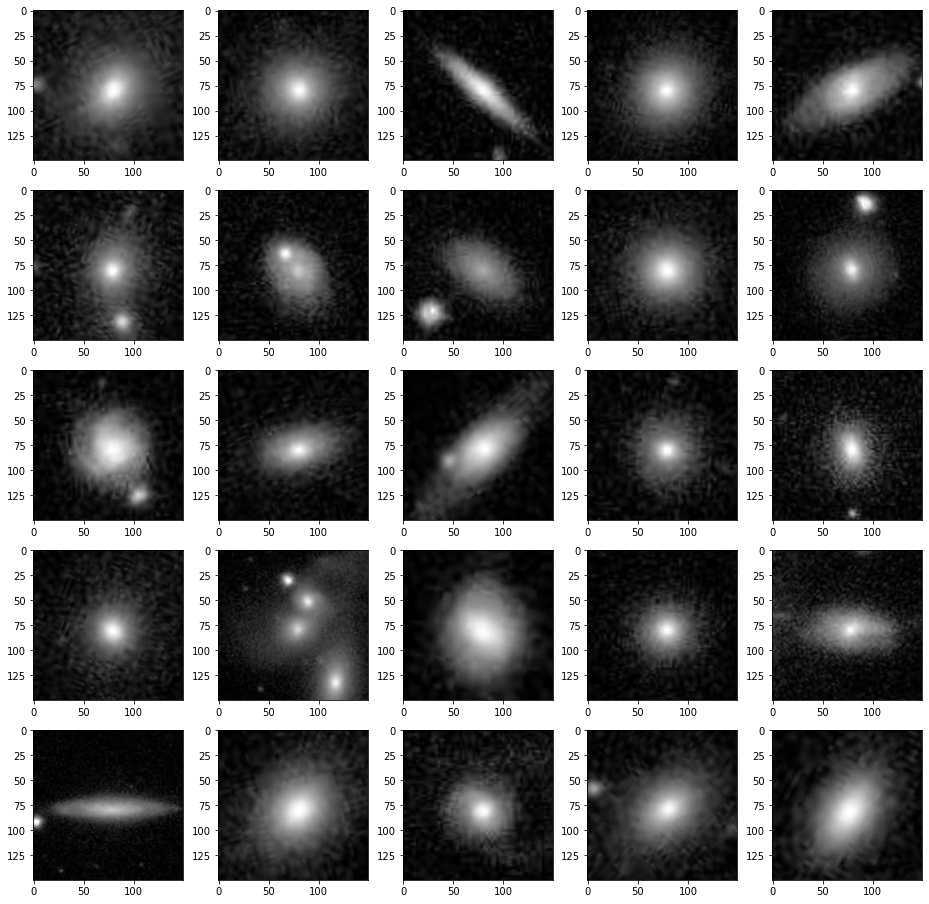

In [4]:
path = "data/images_training_rev1/"
img_list = glob.glob(path+"*.jpg")    

def prepro_galaxies(n_galaxies, path, img_list):
    N = len(img_list)
    selected = np.random.choice(N, 25, replace = False)
    
    plt.figure(figsize=(16,16))
    for i in range(n_galaxies):
        # Je passe l'image en noir et blanc
        img = cv2.imread(img_list[selected[i]], 0)
        # En observant mes images ci-dessus, je décide de croper à 115:300
        img_crop = img[115:300, 115:300]
        # Je descends la résolution sans trop perdre d'info (on passe de 185/185 > 150/150)
        img_resized = cv2.resize(img_crop, (150, 150), interpolation = cv2.INTER_LINEAR)

        plt.subplot(5, 5, i + 1)
        plt.imshow(img_resized, 'gray')

prepro_galaxies(25, path, img_list)

In [7]:
path = "data/images_training_rev1/"
df = pd.read_csv("data/training_solutions_rev1.csv", usecols=[0,1,2,3])

In [6]:
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3
0,100008,0.383147,0.616853,0.000000
1,100023,0.327001,0.663777,0.009222
2,100053,0.765717,0.177352,0.056931
3,100078,0.693377,0.238564,0.068059
4,100090,0.933839,0.000000,0.066161


In [7]:
# Je réparti les galaxies dans des dataframes distinct pour créer des classes
df_rounds = df[(df['Class1.1'] > df['Class1.2']) & (df['Class1.1'] > df['Class1.3'])]
df_disks =  df[(df['Class1.2'] > df['Class1.1']) & (df['Class1.2'] > df['Class1.3'])]
df_stars = df[(df['Class1.3'] > df['Class1.1']) & (df['Class1.3'] > df['Class1.2'])]

In [8]:
print(df_stars.shape)
print(df_disks.shape)
print(df_rounds.shape)

(59, 4)
(34826, 4)
(26679, 4)


#### Affichage des galaxies depuis les dataframes

In [9]:
path = "data/images_training_rev1/"

def show_galx(n_galaxies, path, df):
    N = len(df)
    selected = np.random.choice(N, 25, replace = False)
    selected_idx = df.GalaxyID.values[selected]
    
    plt.figure(figsize=(16,16))
    for i in range(n_galaxies):
        filename = path + str(selected_idx[i]) + ".jpg"
        # Je passe l'image en noir et blanc
        img = cv2.imread(filename, 0)        
        plt.subplot(5, 5, i + 1)
        plt.imshow(img, 'gray')

In [10]:
# Je modifie ma fonction pour que le preprocessing s'applique aux dataframes

path = "data/images_training_rev1/"

def prepro_galaxies_df(n_galaxies, path, df):
    N = len(df)
    selected = np.random.choice(N, 25, replace = False)
    selected_idx = df.GalaxyID.values[selected]
    
    plt.figure(figsize=(16,16))
    for i in range(n_galaxies):
        filename = path + str(selected_idx[i]) + ".jpg"
        # Je passe l'image en noir et blanc
        img = cv2.imread(filename, 0)
        # En observant mes images ci-dessus, je décide de croper à 115:300
        img_crop = img[115:300, 115:300]
        # Je descends la résolution sans trop perdre d'info (on passe de 185/185 > 150/150)
        img_resized = cv2.resize(img_crop, (150, 150), interpolation = cv2.INTER_LINEAR)
        
        plt.subplot(5, 5, i + 1)
        plt.imshow(img_resized, 'gray')

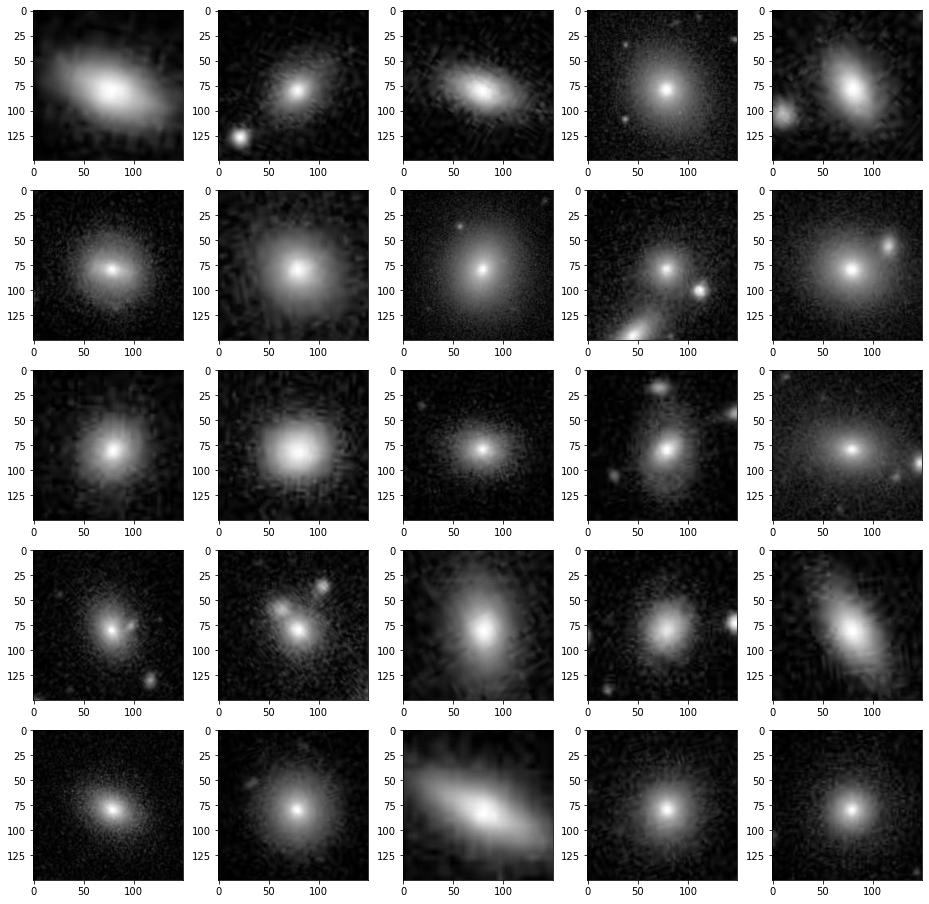

In [11]:
# Galaxies Rondes
prepro_galaxies_df(25, path, df_rounds)

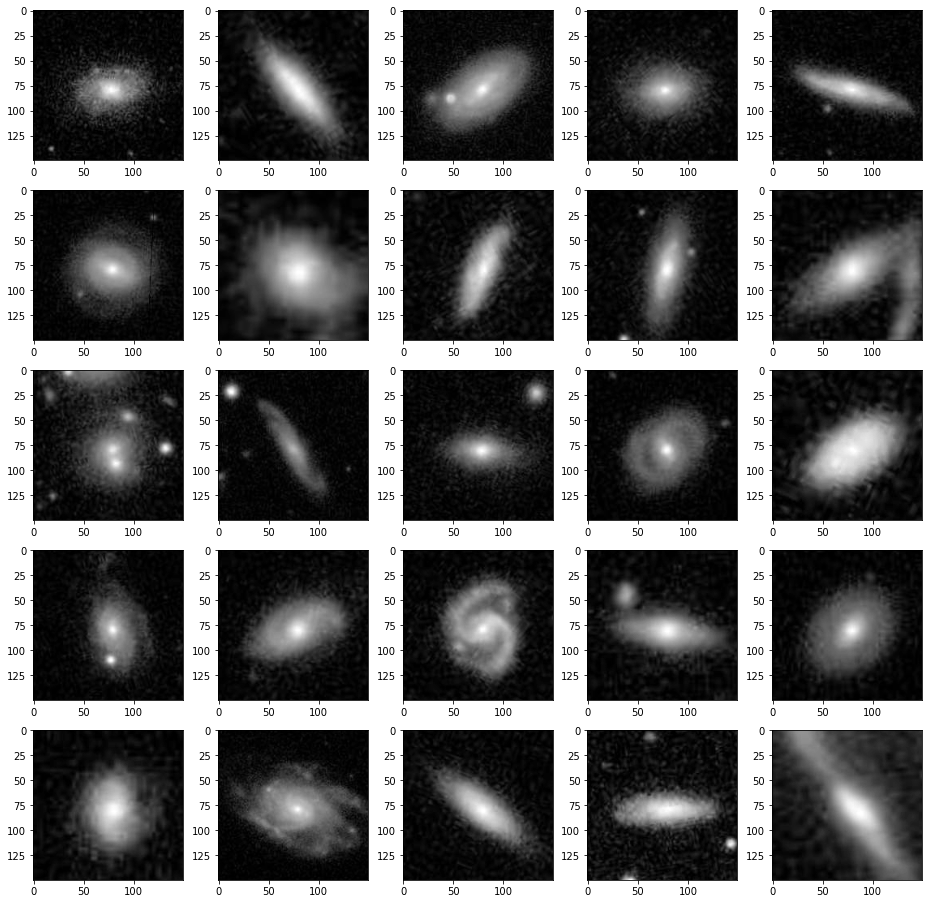

In [12]:
# Galaxies en disque
prepro_galaxies_df(25, path, df_disks)

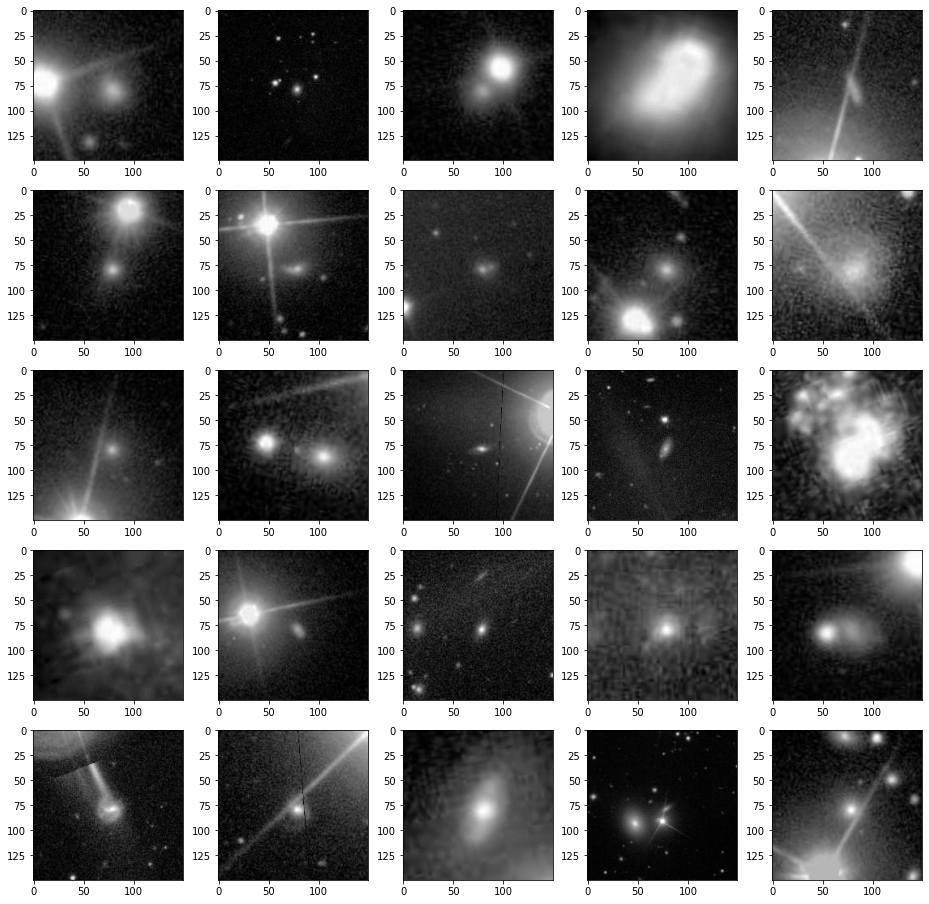

In [13]:
# Etoiles et catégorie Autre
prepro_galaxies_df(25, path, df_stars)

Je pense avoir bien réduit les infos contenus dans chaque image sans trop en perdre.  
On voit que j'aurais peut être pu croper moins serrer mais je vais faire une première tentative comme ça.

#### Pré Processing

In [9]:
def prepro_df(size, path, df, resolution):
    galx = pd.DataFrame([])
    t0 = time.time()
    
    for i in range(size):
        filename = str(df.GalaxyID.values[i])
        img_path = path + str(df.GalaxyID.values[i]) + ".jpg"
        # Je passe l'image en noir et blanc
        img = cv2.imread(img_path, 0)
        # En observant mes images ci-dessus, je décide de croper à 115:300
        img_crop = img[115:300, 115:300]
        # Je descends la résolution
        img_resized = cv2.resize(img_crop, (resolution, resolution), interpolation = cv2.INTER_LINEAR)
        gal = pd.Series(img_resized.flatten(),name= filename)
        galx = galx.append(gal)
        
    runtime = time.time() - t0
    print(f'Execution => {strftime("%H:%M:%S", gmtime(runtime))}')
    return galx

In [16]:
disks = prepro_df(5000, path, df_disks, 64)
rounds = prepro_df(5000, path, df_rounds, 64)
stars = prepro_df(59, path, df_stars,64)

Execution => 00:05:01
Execution => 00:05:01
Execution => 00:00:00


Je rajoute une colonne 'Class' dans chaque df avant de les rassembler

In [19]:
disks['Class'] = 0
rounds['Class'] = 1
stars['Class'] = 2

In [20]:
galaxies = pd.concat([disks, rounds, stars])
galaxies.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,Class
100008,2.0,2.0,4.0,2.0,2.0,5.0,7.0,5.0,3.0,5.0,...,1.0,2.0,1.0,6.0,12.0,10.0,4.0,2.0,5.0,0
100023,1.0,4.0,6.0,7.0,6.0,7.0,10.0,13.0,14.0,8.0,...,17.0,19.0,22.0,34.0,28.0,16.0,11.0,6.0,7.0,0
100134,4.0,3.0,5.0,5.0,5.0,5.0,2.0,7.0,6.0,5.0,...,5.0,9.0,17.0,20.0,27.0,22.0,33.0,27.0,9.0,0
100143,1.0,3.0,0.0,4.0,3.0,1.0,0.0,1.0,1.0,0.0,...,9.0,6.0,7.0,3.0,3.0,7.0,2.0,4.0,3.0,0
100150,2.0,1.0,3.0,3.0,4.0,3.0,6.0,9.0,9.0,5.0,...,4.0,6.0,8.0,8.0,8.0,13.0,17.0,9.0,4.0,0


### Classification sans Deep Learning

#### Préparation des datas pour l'entrainement des modèles

In [21]:
X = galaxies.drop(['Class'], axis = 1)
Y = galaxies['Class']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

#### Standardisation

In [22]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train.shape

(8047, 4096)

#### PCA

In [23]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
nb_dim = np.argmax(cumsum >= 0.90) + 1

print("Nombre de composants expliquant 95% de la variance :", nb_dim)

Nombre de composants expliquant 95% de la variance : 160


In [24]:
pca = PCA(n_components= nb_dim)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape

(8047, 160)

In [25]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC

def train_models():
    models = {
              'KNN' : KNeighborsClassifier(n_neighbors = 20),
              'SVM' : SVC(gamma='auto'),
              'RandomForest' : RandomForestClassifier(),
              'DecisionTree' : DecisionTreeClassifier()
             }

    model_list = []
    runtime_list = []
    scor_list = []

    for k, v in models.items() :

        t0 = time.time() 
        model = v
        model.fit(X_train_pca, Y_train)
        runtime = time.time() - t0

        model_list.append(k)
        runtime_list.append(strftime("%H:%M:%S", gmtime(runtime)))

        # Score
        scor = model.score(X_test_pca, Y_test)
        scor_list.append(round(scor, 2))

        print(f"Le modèle {k} s'est terminé en {runtime} pour {round(scor, 2)}")
    result = pd.DataFrame({'Model ' : model_list,
                           'Run time' : runtime_list,
                           'Accuracy Score' : scor_list})
    result.sort_values(by=['Accuracy Score'], ascending = True)
    return result

In [26]:
train_models()

Le modèle KNN s'est terminé en 0.2907114028930664 pour 0.73
Le modèle SVM s'est terminé en 26.970964193344116 pour 0.65
Le modèle RandomForest s'est terminé en 6.922057390213013 pour 0.72
Le modèle DecisionTree s'est terminé en 1.5630218982696533 pour 0.64


,Model,Run time,Accuracy Score
0,KNN,00:00:00,0.73
1,SVM,00:00:26,0.65
2,RandomForest,00:00:06,0.72
3,DecisionTree,00:00:01,0.64


### Classification avec Deep Learning  -- CNN Image Classification

In [8]:
def prepro_galaxies_array(size, path, df, resolution):
    gal_x = []
    selection = df.values
    idx = selection[:,0].astype(int).astype(str)
    gal_y = selection[:,1:]
    
    t0 = time.time()
    for i in range(size):
        filename = str(df.GalaxyID.values[i])
        img_path = path + str(df.GalaxyID.values[i]) + ".jpg"
        
        img = cv2.imread(img_path, 0)
        img_crop = img[115:300, 115:300]
        img_resized = cv2.resize(img_crop, (resolution, resolution), interpolation = cv2.INTER_LINEAR)
        img_cleaned = img_resized/255.
        gal_x.append(img_cleaned)
    
    gal_x = np.array(gal_x)        
    runtime = time.time() - t0
    print(f'Execution => {strftime("%H:%M:%S", gmtime(runtime))}')
    return gal_x, gal_y

In [9]:
gal_x, gal_y = prepro_galaxies_array(len(df), path, df, 64)

Execution => 00:00:54


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(gal_x, gal_y, test_size = 0.35)

#### Construction du modèle CNN

In [11]:
#Librairies
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization

In [45]:
def build_model(shape):
    model = Sequential()
    
    # Couche 1
    model.add(Conv2D(32, (3, 3), input_shape = (shape, shape, 1), activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    # Couche 2
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    # Couche 3
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    
    # Couche 4
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    
#     # Couche 5
#     model.add(Conv2D(512, (3, 3), activation = 'relu'))
#     model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'sigmoid'))
    
    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    print(model.summary())
    return model

In [39]:
model = build_model(64)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 128)        

In [46]:
def cnn_pipe(shape, X_train, X_test) :
    model = build_model(shape)
    
    X_train = X_train.reshape(X_train.shape[0], shape, shape, 1)
    X_test = X_test.reshape(X_test.shape[0], shape, shape, 1)
    
    model.fit(X_train, Y_train, epochs=30, validation_data=(X_test, Y_test))

    # evaluate model
    _, acc = model.evaluate(X_test, steps=len(X_test), verbose=0)
    print('> %.3f' % (acc * 100.0))

    return model

In [47]:
model_one = cnn_pipe(64, X_train, X_test,)
model_one

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 4, 128)        

On termine avec une val_accuracy à 0.83 et une accuracy à 0.90 sur le dernier passage.  
Il y a un peu de surapprentissage, peut-être dû au fait que certaines images sont quasiment identiques.  
Je pense qu'il est possible d'optimiser le modèle en jouant sur le nombre de neurones.